# Setup

In [1]:
# Downloading historical data

import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
abalone = pd.read_csv(url, header=None)

In [2]:
abalone.head()

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
# Missing column names available here - https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/

abalone.columns = [
    "Sex",
    "Length",
    "Diameter",
    "Height",
    "Whole weight",
    "Shucked weight",
    "Viscera weight",
    "Shell weight",
    "Rings",
]


In [5]:
abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [6]:
# Removing `sex` column as the goal is to use physical measurements only to predict the age of the abalone. Age is measured by the number of `Rings` on the shell
abalone = abalone.drop("Sex", axis=1)

# kNN from scratch

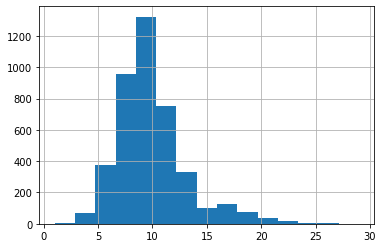

In [9]:
import matplotlib.pyplot as plt
abalone["Rings"].hist(bins=15)
plt.show()

# Histogram showing the distribution of abalones based on the number of rings

In [10]:
# Scanning for variables that have a strong correlation with age
correlation_matrix = abalone.corr()
correlation_matrix["Rings"]

Length            0.556720
Diameter          0.574660
Height            0.557467
Whole weight      0.540390
Shucked weight    0.420884
Viscera weight    0.503819
Shell weight      0.627574
Rings             1.000000
Name: Rings, dtype: float64

In [16]:
# Example of calculating the distance between data points

import numpy as np
a = np.array([2,2])
b = np.array([4,4])
np.linalg.norm(a - b)  #  vector C, from the head of vector A to the head of vector B

2.8284271247461903

In [14]:
# Casting to numpy arrays

X = abalone.drop("Rings", axis = 1).values  # independent variables, everything but Rings
y = abalone["Rings"].values  # dependent variable, target

In [19]:
# Fake set for a new abalone

new_data_point = np.array([
    0.569552,
    0.446407,
    0.154437,
    1.016849,
    0.439051,
    0.222526,
    0.291208,
])

In [21]:
# Distances between the new data point and each of the existing data points in the abalone set

distances = np.linalg.norm(X - new_data_point, axis = 1)
distances

array([0.59739395, 0.9518455 , 0.40573594, ..., 0.20397872, 0.14342627,
       1.10583307])

In [22]:
# Using K=3 to determine the three closest neighbors

k = 3
nearest_neighbor_ids = distances.argsort()[:k]
nearest_neighbor_ids

array([4045, 1902, 1644])

In [24]:
# Rings from nearest neighbors

nearest_neighbor_rings = y[nearest_neighbor_ids]
nearest_neighbor_rings

array([ 9, 11, 10])

In [27]:
# Predicting with regression - average. Target variable is numeric

prediction = nearest_neighbor_rings.mean()
prediction

10.0

In [30]:
# Example - predicting with classification - mode. Target variable is categorical

# Mode is the value that occurs more often. The prediction is the value that occurs most often among the neighbors. There are multiple ways to deal with clashes between neighbords (diff prediction for two or more neighbors): randomzing, distance or other factors.

import scipy.stats
class_neighbors = np.array(["A", "B", "B", "C"])  # neighbors classes
scipy.stats.mode(class_neighbors)

ModeResult(mode=array(['B'], dtype='<U1'), count=array([2]))

# Predicting with scikit-learning

In [35]:
# Evaluating quality of the model with train-test split. Train = fit the model, Test = evaluate the model.

from sklearn.model_selection import train_test_split

# Depends on the cell that converts the Abalone frame to numpy arrays
# 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [37]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train, y_train)

# yeap, it's that easy

KNeighborsRegressor(n_neighbors=3)

In [40]:
# Checking if the model sucks or not using training data and RMSE
# https://en.wikipedia.org/wiki/Root-mean-square_deviation
# https://realpython.com/knn-python/#using-scikit-learn-to-inspect-model-fit

from sklearn.metrics import mean_squared_error
from math import sqrt

train_predictions = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_predictions)
rmse = sqrt(mse)
print(f"Trained data RMSE: {rmse}")

test_predicitons = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_predicitons)
rmse = sqrt(mse)
print(f"Test data RMSE: {rmse}")



Trained data RMSE: 1.653705966446084
Test data RMSE: 2.375417924000521


Diff between trained and test show that test perform resonably worse possibly due to overfitting. Checking that hypothesis with plots.

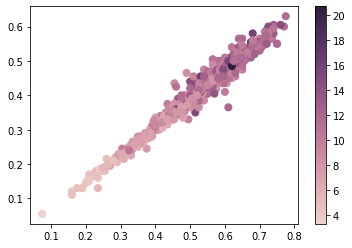

In [43]:
# Create a scatter plot of the first and second columns of X_test by subsetting the arrays X_test[:,0] and X_test[:,1]. The first two columns are `Lenght` and `Diameter` (which had high scores when checking the correlations)
# https://realpython.com/knn-python/#plotting-the-fit-of-your-model

import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(X_test[:, 0], X_test[:, 1], c=test_predicitons, s=50, cmap=cmap)
f.colorbar(points)
plt.show()

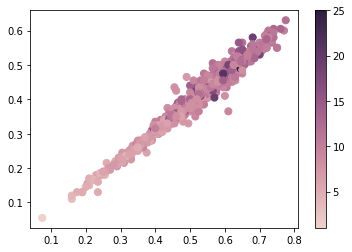

In [44]:

# Checking if the same trend exists in actual abalone data
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=cmap)
f.colorbar(points)
plt.show()

# Tunning

In [45]:
# Finding the optimal K (1 would suffer from outliers, larger number would produce the same prediction)

from sklearn.model_selection import GridSearchCV

parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50)})

In [46]:
# Best value of K
gridsearch.best_params_

{'n_neighbors': 25}

In [50]:
# Checking if the model improved with new K.  

train_predictions_grid = gridsearch.predict(X_train)
mse = mean_squared_error(y_train, train_predictions_grid)
rmse = sqrt(mse)
print(f"Trained data RMSE: {rmse}")

test_predictions_grid = gridsearch.predict(X_test)
mse = mean_squared_error(y_test, test_predictions_grid)
rmse = sqrt(mse)
print(f"Test data RMSE: {rmse}")

Trained data RMSE: 2.0731180327543384
Test data RMSE: 2.1700197339962175


^ Train data is worse than before, but test data performed better!

In [53]:
# Using weights to make neighbors that are futher away less strongly influence the prediction

parameters = {
    "n_neighbors": range(1, 50),
    "weights": ["uniform", "distance"]
}

gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train, y_train)
print(gridsearch.best_params_)

test_predictions_grid = gridsearch.predict(X_test)
mse = mean_squared_error(y_test, test_predictions_grid)
rmse = sqrt(mse)
rmse

{'n_neighbors': 25, 'weights': 'distance'}


2.1634265584947485

^ Marginal improvement, but still better than before.

In [57]:
# Testing out Bagging - average of lots of model predictions with slight variations would be wrong less often than just running a single model.

best_k = gridsearch.best_params_["n_neighbors"]
best_weights = gridsearch.best_params_["weights"]
bagged_knn = KNeighborsRegressor(n_neighbors=best_k, weights=best_weights)

from sklearn.ensemble import BaggingRegressor
bagging_model = BaggingRegressor(bagged_knn, n_estimators=100)
bagging_model.fit(X_train, y_train)

test_predictions_grid = bagging_model.predict(X_test)
mse = mean_squared_error(y_test, test_predictions_grid)
rmse = sqrt(mse)
rmse

2.16272939634756

^ Another marginal improvement, but still better than before